In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 16000
new_sr = 8000
dropout = 0.3
half = False
root = '../'

In [2]:
device = 0
device_ids = [0, 1, 2, 3]

In [3]:
def load(filename):
    samples = np.load(filename)/(2**15)
    samples = resample(samples, old_sr, new_sr)
    # pad the samples
    if len(samples)>2*new_sr:
        samples = samples[:2*new_sr]
    if len(samples)<2*new_sr:
        padding = np.zeros(2*new_sr-len(samples))
        samples = np.concatenate([samples, padding])
    return samples


def make_spectrogram(segment):
    segment = segment[50:-50] # make size 200
    S = np.abs(librosa.stft(segment, n_fft = 255, hop_length = 125)) # 32 ms window, 16 ms hop
    return S

# def compute_mean_std(csv):
#     csv = pd.read_csv(csv)
#     mean = np.zeros((128, 1))
#     var = np.zeros((128, 1))
#     frames = 0
#     for i in range(200):
#         row = csv.iloc[i]
#         sig1, sig2 = load(root+row['first_file']), load(root+row['second_file'])
#         spec_dB = np.log(1+make_spectrogram(sig1+sig2))
#         mean+=np.sum(spec_dB, axis = 1, keepdims=True)
#         var+=np.sum(spec_dB**2, axis = 1, keepdims=True)
#         frames+=spec_dB.shape[1]
#     mean = mean / frames
#     std = np.sqrt(var / frames - mean**2)
#     return mean, std


class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.overlays = pd.read_csv(csv)
        self.speakers = list(set(self.overlays['first_speaker']).union(set(self.overlays['second_speaker'])))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.overlays)
    def __getitem__(self, idx):
        overlay = self.overlays.iloc[idx]
        first_segment = load(root+overlay['first_file'])
        second_segment = load(root+overlay['second_file'])

        spec1 = np.log(1+make_spectrogram(first_segment))[None, ...]
        spec2 = np.log(1+make_spectrogram(second_segment))[None, ...]
        source = np.log(1+make_spectrogram(first_segment+second_segment))[None, ...]
        
        return source, np.concatenate((spec1, spec2), axis = 0)


#mean, std = compute_mean_std('overlay-train.csv')


trainset = OverlayDataSet('overlay-train.csv')
valset = OverlayDataSet('overlay-val.csv')
testset = OverlayDataSet('overlay-test.csv')

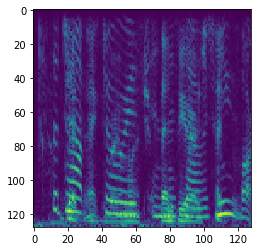

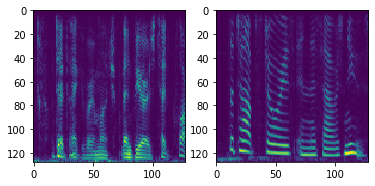

In [4]:
source, targets = trainset[3]
plt.imshow(source[0][::-1])
plt.figure()
plt.subplot(121)
plt.imshow(targets[0][::-1])
plt.subplot(122)
plt.imshow(targets[1][::-1])

## Maybe try drastically increasing channel number in residual attention stage to see if it overfits

In [5]:
# import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(128, 128), size2=(64, 64), size3=(32, 32), out_skip = True):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, in_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, in_channels),
            ResidualBlock(in_channels, in_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, in_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, in_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, in_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, in_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, in_channels),
            ResidualBlock(in_channels, in_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, in_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, in_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)
        self.out_skip = out_skip
        
    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        if self.out_skip:
            out = (1 + out_softmax6) * out_trunk
        else:
            out = out_softmax6 * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads_2 = 4 # MHA heads

In [6]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation):
        super(DepthwiseSeparableConv, self).__init__()
        # Use `groups` option to implement depthwise convolution
        # [M, H, K] -> [M, H, K]
        depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   stride=stride, dilation = dilation, padding=padding, groups=in_channels,
                                   bias=False)

        prelu = nn.PReLU()
        norm = nn.BatchNorm2d(in_channels)
        # [M, H, K] -> [M, B, K]
        pointwise_conv = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        # Put together
        self.net = nn.Sequential(depthwise_conv, prelu, norm,
                                     pointwise_conv)

    def forward(self, x):
        """
        Args:
            x: [M, H, K]
        Returns:
            result: [M, B, K]
        """
        return self.net(x)


In [7]:
load_model = True
model_to_load = 'models/extractor.pth'
num_speakers = 2
extractor = nn.Sequential(ResidualBlock(1, 128),
                         AttentionModule_stage1(128, 64),
                         AttentionModule_stage1(64, 128),
                         AttentionModule_stage1(128, num_speakers),
                         nn.ReLU()
                         ).cuda(device)

optimizer = torch.optim.Adam(extractor.parameters(), 0.0005)

if load_model and os.path.exists(model_to_load):
    print('load model')
    checkpoint = torch.load(model_to_load)
    extractor.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
else:
    print('initializing new model')
    bestloss = 999
print('bestloss', bestloss)

extractor = torch.nn.DataParallel(extractor, device_ids = device_ids)

load model
bestloss 0.021930576107321943


In [8]:
def cal_loss(source, estimate_source):
    """
    Args:
        source: [B, C, T, F], B is batch size, F is frequency
        estimate_source: [B, C, T, F]
        source_lengths: [B, F]
    """
    min_mse, perms, min_mse_idx = cal_mse(source,estimate_source)
    loss = torch.mean(min_mse)
    reorder_estimate_source = reorder_source(estimate_source, perms, min_mse_idx)
    return loss, min_mse, estimate_source, reorder_estimate_source


def cal_mse(source, estimate_source):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, T, F], B is batch size
        estimate_source: [B, C, T, F]
        source_lengths: [B], each item is between [0, T]
    """
    assert source.size() == estimate_source.size()
    B, C, T, F = source.size()


    # Step 2. SI-SNR with PIT
    # reshape to use broadcast
    s_target = torch.unsqueeze(source, dim=1)  # [B, 1, C, T, F]
    s_estimate = torch.unsqueeze(estimate_source, dim=2)  # [B, C, 1, T, F]
    # s_target = <s', s>s / ||s||^2
    pair_wise_mse = torch.sum((s_estimate - s_target)**2, dim=(3, 4))/T/F  # [B, C, C]

    ############## since distribution is asymmetric, use l2 not l1 loss ###########
    
    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    mse_set = torch.einsum('bij,pij->bp', [pair_wise_mse, perms_one_hot])
    min_mse_idx = torch.argmin(mse_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    min_mse, _ = torch.min(mse_set, dim=1, keepdim=True)
    min_mse /= C
    return min_mse, perms, min_mse_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, T]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, T]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    # print('max_snr_perm', max_snr_perm)
    # maybe use torch.gather()/index_select()/scatter() to impl this?
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source





## If overfit, try adding depthwise separable convolution to bottleneck

In [9]:
batch_size = 50
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True, pin_memory = True, num_workers = 16)
criterion = torch.nn.BCELoss()

for epoch in range(8, 64):
    running_loss = 0.0
    extractor.train()
    for batch_idx, (mixture, targets) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
        outs = extractor(mixture)
        loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.5)
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.4f ' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestloss': bestloss
            }, 'models/extractor.pth')
            
    
    extractor.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (mixture, targets) in enumerate(tqdm(valloader)):
            num_samples = mixture.shape[0]
            mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
            outs = extractor(mixture)
            loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
            running_loss += loss.item()*num_samples
            
        running_loss /= len(valset)
        print('val loss: %.3f ' % (running_loss))
        
        if running_loss < bestloss:
            bestloss = running_loss
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bestloss': bestloss
            }, 'models/best-extractor.pth')

KeyboardInterrupt: 

Text(0.5, 1.0, 'output 2(without dilation)')

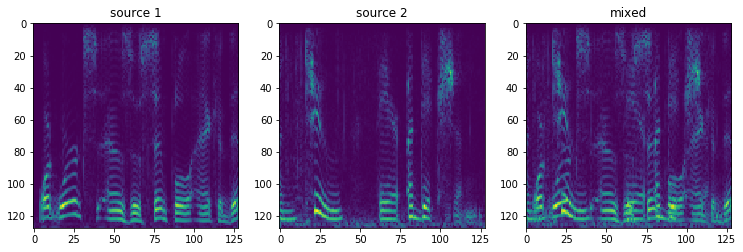

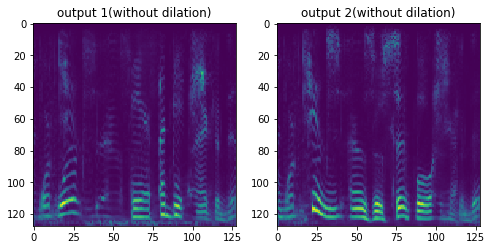

In [42]:
checkpoint = torch.load('models/best-extractor.pth')
extractor.module.load_state_dict(checkpoint['model_state_dict'])
mixture, targets = testset[17]
plt.figure(figsize = (12.5, 4))
plt.subplot(131)
plt.imshow(targets[0][::-1])
plt.title('source 1')
plt.subplot(132)
plt.imshow(targets[1][::-1])
plt.title('source 2')
plt.subplot(133)
plt.imshow(mixture[0][::-1])
plt.title('mixed')

new_spec1, new_spec2 = extractor(torch.Tensor(mixture[None, ...]).cuda(device))[0].detach().cpu().numpy()
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.imshow(new_spec1[::-1])
plt.title('output 1(without dilation)')
plt.subplot(122)
plt.imshow(new_spec2[::-1])
plt.title('output 2(without dilation)')


In [10]:
class OverlayNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln = nn.LayerNorm(256)
        self.downsample1 = ResidualBlock(1, num_heads, (1, 2))
        self.res_att = AttentionModule_stage1(num_heads, num_heads)  # batch_size * num_heads * L *128
        self.downsample2 = nn.Sequential(ResidualBlock(num_heads, num_heads//2),
                                        ResidualBlock(num_heads//2, 2),
                                        ResidualBlock(2, 2, (1, 2)))
        self.reshape =  Lambda(lambda x: x.permute((1, 2, 0, 3))) # num_heads, L, batch_size, n_features
        self.lstm = nn.LSTM(64, 32, 2, batch_first = False, bidirectional = True, dropout = dropout) # L * batch_size * n_hidden
        self.mha =  torch.nn.MultiheadAttention(64, num_heads = num_heads_2, dropout=dropout, bias=True, kdim=64, vdim=64) # L * batch * 64
        self.fc1 = nn.Linear(64, 32) # L * batch * 32
        self.average = Lambda(lambda x: x.mean(dim = 0)) # batch * n_hidden
        self.tanh = nn.Tanh() # batch * 32
        #self.norm = Lambda(lambda x: torch.nn.functional.normalize(x, p = 2, dim = 1)) # L2 normalize across n_hidden
        self.fc2 = nn.Linear(32, 20) # batch * 20
        self.softmax = nn.Softmax(1) 
    def forward(self, X):
        X = self.ln(X)
        X = self.downsample1(X)
        #print('first downsample ', X.shape)
        X = self.res_att(X)
        #print('residual attention ', X.shape)
        X = self.downsample2(X)
        #print('second downsample ', X.shape)
        X = self.reshape(X)
        X1, X2 = X[0], X[1]
        X1,_ = self.lstm(X1)
        X2,_ = self.lstm(X1)
        #print('lstm ', X.shape)
        X1,_ = self.mha(X1, X1, X1)
        X2,_ = self.mha(X2, X2, X2)
        #print('mha ', X.shape)
        X1 = self.fc1(X1)
        X2 = self.fc1(X2)
        #print('dense ', X.shape)
        X1 = self.average(X1)
        X2 = self.average(X2)
        #print('mean ', X.shape)
        X1 = self.tanh(X1)
        X2 = self.tanh(X2)
        X1 = self.fc2(X1)
        X2 = self.fc2(X2)
        X1 = self.softmax(X1)
        X2 = self.softmax(X2)
        X = torch.stack([X1,X2], dim=0)
        X,_ = torch.max(X, dim=0)
        return X
    
    
overnet = OverlayNet().cuda(device)
    
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(overnet.parameters(), 0.001)

if os.path.exists('models/overnet8.pth'):
    print('load model')
    checkpoint = torch.load('models/overnet8.pth')
    overnet.load_state_dict(checkpoint['model_state_dict'])
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        print('cannot load optimizer')
    loss = checkpoint['loss']
    if 'bestacc' in checkpoint:
        bestacc = checkpoint['bestacc']
    else:
        bestacc = 0.0
else:
    print('initializing new model')
    bestacc = 0.0
    
if half:
    overnet.half()  # convert to half precision
    for layer in overnet.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.float()
            
overnet.train()
'bestacc:', bestacc

NameError: name 'num_heads' is not defined

## Also Do metrics on hitting a single person right
## Theoretical justification that when reducing number of channels, neural network could learn to pair similar spectrum representations with each other: only pitch lines that are greater than a certain threshold will pass relu and become postivie. Batchnorm makes this effect stronger. Therefore, when two channels represent spectrums of different people, when they are added the output will be nothing if it doesn't pass the relu threshold

In [5]:
batch_size = 128
def find_max2(tensor):
    array = tensor.cpu().detach().numpy()
    max2 = []
    for row in array:
        max2.append(np.argsort(row)[::-1][:2])
    return np.array(max2)

def compute_corrects(tensor1, tensor2):
    max_1, max_2 = find_max2(tensor1), find_max2(tensor2)
    batch_size = max_1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if Counter(max_1[i])==Counter(max_2[i]):
            batch_corrects+=1
    return batch_corrects

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
criterion = torch.nn.BCELoss()

for epoch in range(64):
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, (spec, target) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        spec, target = spec.float(), target.float()
        if half:
            spec, target = spec.half(),target.half()
        spec = spec.cuda(device)
        target = target.cuda(device)

        out = overnet(spec)
        loss = criterion(out, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(overnet.parameters(), 0.5)
        optimizer.step()
                
        running_loss += loss.item()
        running_accuracy += compute_corrects(out, target)/batch_size
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': overnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/overnet8.pth')

        
    with torch.no_grad():
        corrects = 0
        for batch_idx, (spec, target) in enumerate(tqdm(valloader)):
            spec, target = spec.float(), target.float()
            if half:
                spec, target = spec.half(), target.half()
            spec = spec.cuda(device)
            target = target.cuda(device)
            overnet.eval()
            out = overnet(spec) 
            corrects += compute_corrects(out, target)
        print('val acc:', corrects/len(valset))
        if corrects/len(valset) > bestacc:
            bestacc = corrects/len(valset)
            torch.save({
            'model_state_dict': overnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestacc': bestacc
            }, 'models/best-overnet8.pth')
        overnet.train()
        pass

[1,   200] loss: 0.007 accuracy: 0.985
[1,   400] loss: 0.007 accuracy: 0.986
[1,   600] loss: 0.006 accuracy: 0.987




val acc: 0.9254990925589837


[2,   200] loss: 0.006 accuracy: 0.987
[2,   400] loss: 0.006 accuracy: 0.987
[2,   600] loss: 0.007 accuracy: 0.983




val acc: 0.9252268602540835


[3,   200] loss: 0.005 accuracy: 0.989
[3,   400] loss: 0.006 accuracy: 0.985


KeyboardInterrupt: 

In [6]:
checkpoint = torch.load('models/best-overnet8.pth')
overnet.load_state_dict(checkpoint['model_state_dict'])

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
        
corrects = 0
for batch_idx, (spec, target) in enumerate(tqdm(testloader)):
    spec, target = spec.float(), target.float()
    if half:
        spec, target = spec.half(), target.half()
    spec = spec.cuda(device)
    target = target.cuda(device)
    overnet.eval()
    out = overnet(spec) 
    corrects += compute_corrects(out, target)
print('test acc:', corrects/len(testset))
overnet.train()
pass

KeyboardInterrupt: 

In [7]:
modulelist2 = list([overnet.downsample1, overnet.res_att, overnet.downsample2])
modulelist1 = list([overnet.downsample1, overnet.res_att])
modulelist0 = list([overnet.downsample1])
extractor2 = nn.Sequential(*modulelist2)
extractor1 = nn.Sequential(*modulelist1)
extractor0 = nn.Sequential(*modulelist0)

Text(0.5, 1.0, 'output 2')

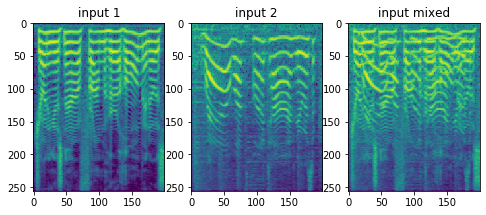

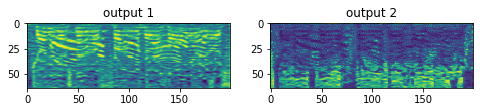

In [20]:
visualset = OverlayDataSet('overlay-test.csv', True)
idx = np.random.randint(len(visualset))
spec1, spec2, spec, target = visualset[idx]
spec = torch.Tensor(spec).cuda(device).float()[None, ...]

out0 = extractor0(spec)[0].detach().cpu().numpy()
out1 = extractor1(spec)[0].detach().cpu().numpy()
out2 = extractor2(spec)[0].detach().cpu().numpy()

#out = out.reshape(-1, out.shape[-1])
# out0 = np.concatenate(out0, axis = 1)
# out1 = np.concatenate(out1, axis = 1)
# out2 = np.concatenate(out2, axis = 1)
plt.figure(figsize = (8, 16))
plt.subplot(131)
plt.imshow(spec1[0].T)
plt.title('input 1')
plt.subplot(132)
plt.imshow(spec2[0].T)
plt.title('input 2')
plt.subplot(133)
plt.imshow(spec[0][0].detach().cpu().numpy().T)
plt.title('input mixed')
# plt.figure(figsize = (32, 8))
# plt.imshow(out0.T)
# plt.figure(figsize = (32, 8))
# plt.imshow(out1.T)
plt.figure(figsize = (8, 16))
plt.subplot(121)
plt.imshow(out2[0].T)
plt.title('output 1')
plt.subplot(122)
plt.imshow(out2[1].T)
plt.title('output 2')